In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_colwidth = 400

%matplotlib inline

In [2]:
data_directory = os.path.join('..','data','')
csv_path = os.path.join(data_directory, 'twitter_hate_speech.csv')
df_orig = pd.read_csv(csv_path, engine = 'python', delimiter = ',')

In [3]:
df_orig.columns = ['id', 'golden','state', 'trusted_judgements','last_judgment','is_hate_speech','confidence',
                   'created','orig_golden','orig_last_judgement','orig_trusted_judgements','orig_id','orig_state',
                   'updated','orig_is_hate_speech','is_hate_speech_gold','reason','confidence2','id2','text']

# Drop columns

In [4]:
df = df_orig.dropna(thresh = 68, axis = 'columns')
df = df.set_index('id')

In [5]:
df.head()

,golden,state,trusted_judgements,last_judgment,is_hate_speech,confidence,id2,text
id,,,,,,,,
853718217,True,golden,86,NaN,The tweet uses offensive language but not hate speech,0.6013,1.666196e+09,Warning: penny boards will make you a faggot
853718218,True,golden,92,NaN,The tweet contains hate speech,0.7227,4.295121e+08,Fuck dykes
853718219,True,golden,86,NaN,The tweet contains hate speech,0.5229,3.956238e+08,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandonernandez @bootyacid at least i dont look like jefree starr faggot
853718220,True,golden,98,NaN,The tweet contains hate speech,0.5184,4.975147e+08,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkillah Is a fag"" jackie jealous"" Neeeee"
853718221,True,golden,88,NaN,The tweet uses offensive language but not hate speech,0.5185,5.889236e+08,@Zhugstubble You heard me bitch but any way I'm back th texas so wtf u talking about bitch ass nigga


# Recode hate speech classifications

In [6]:
df = df[['text','is_hate_speech']]
categories = df.is_hate_speech.unique()
df['is_hate_speech'] = df['is_hate_speech'].replace(categories, [1,2,0])

# Things to clean up
- twitter handles
- emoticons
- urls
- newlines
- hashtags
- duplicate tweets

In [7]:
df.head()

,text,is_hate_speech
id,,
853718217,Warning: penny boards will make you a faggot,1
853718218,Fuck dykes,2
853718219,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandonernandez @bootyacid at least i dont look like jefree starr faggot,2
853718220,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkillah Is a fag"" jackie jealous"" Neeeee",2
853718221,@Zhugstubble You heard me bitch but any way I'm back th texas so wtf u talking about bitch ass nigga,1


In [8]:
import re

replace_user = lambda tweet: re.sub(r'(@\w+\s*)', r'<user> ', tweet)
clean_tweet = lambda tweet: \
re.sub(r'(@\w+\s*)|#|&|\(|\)|\"|\.|\?|!|,|;|:|(https?://\S*)|(�\S*\d*)|(128\d{3})|(_*UNDEF)',
                      ' ', tweet)

In [9]:
import spacy
nlp = spacy.load('en')

In [10]:
def normalize(tweet):
    x = tweet.split()
    y = ''
    for token in x:
        y = ' '.join([y,token.lower()])
    return y[1:]

In [11]:
start = 4000
offset = 10

df_clean = df.copy()
df_clean['text'] = df_clean['text'].apply(replace_user)
df_clean['text'] = df_clean['text'].apply(clean_tweet)
df_clean['text'] = df_clean['text'].apply(normalize)
df_clean.iloc[start:start+offset,:]

,text,is_hate_speech
id,,
853723375,2016 nigga's should start cuffin these women amp women should start being down for them _,2
853723376,cuffin these bitches you niggas is cops,1
853723377,paigons cuffin these thots word to mum bro thats un cool got a bad b in the nizz she wanna let her hair down like rapunzel,0
853723378,_ why y'all cuffin these hoes man,1
853723379,i ain't be cuffin these hoes i just be fuckin these hoes,1
853723380,stop cuffin these hoes <user> _,1
853723381,these niggas be cuffin these hoes that be flip floppin but not the ones that been down for them since day one okaay _,2
853723382,u cuffin these hoes u don't know no better,1
853723383,stop cuffin' these hoes in 2016,1


# Duplicate tweets need to be addressed

In [12]:
df_clean.text.value_counts()

<user> shut up nigger                                                                                                                        36
1 2 3 1 2 3 4 how many niggers are in my store                                                                                               35
amid economic recovery school districts desperate for bus drivers when unemployment is high school district                                  27
[drum and bass] btsm x lektrique - religion muzzy remix -                                                                                    21
1 2 3 4 how many niggers are in my store                                                                                                     14
123 123 4 how many niggers are in my store                                                                                                   14
governors have no right to reduce n18 000 minimum wage ngige via <user>                                                                 

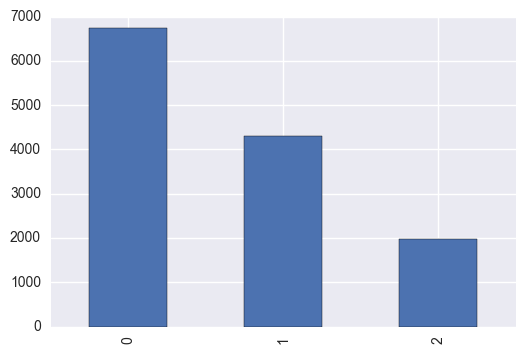

In [13]:
df_clean = df_clean.drop_duplicates(subset = 'text')
df_clean.is_hate_speech.value_counts().plot(kind = 'bar')

In [14]:
with open('../data/corpus_cnn_glove.txt','wt') as file_out:
    for tweet in df_clean.text:
        file_out.write(tweet + '\n')

# Processing into learnable form

In [15]:
np.random.seed(1701)

from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Activation, Embedding, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [16]:
# create 100-dimensional vector embeddings for words that appear in the corpus at least 2 times
embedding_dimension = 100
model = Word2Vec([tweet.split() for tweet in df_clean.text], min_count = 2, size = embedding_dimension,
                 window = 10, sg = 1)
max_vocab_size = len(model.wv.vocab)
print('word2vec vocabulary size:', max_vocab_size)

word2vec vocabulary size: 7235


In [17]:
# tokenize each tweet in the corpus. this will be useful for embedding each tweet as an index sequence vector
tokenizer = Tokenizer(num_words = max_vocab_size)
tokenizer.fit_on_texts(df_clean.text)
print('tokenizer vocabulary size:', tokenizer.num_words)

tokenizer vocabulary size: 7235


In [18]:
def glove_generator():
    with open('../data/glove_embeddings/glove.twitter.27B.100d.txt', 'rb') as file_in:
        for line in file_in:
            split_line = line.split()
            word = split_line[0]
            vector = [float(val) for val in split_line[1:]]
            yield word, vector

In [19]:
def find_vector(word):
    for gen_word, gen_vector in glove_generator():
        if word == gen_word.decode('utf8'):
            return np.array(gen_vector)

In [20]:
from IPython.display import clear_output
import pickle as pkl

retrain = False

if retrain:
    # create embedding matrix where each row corresponds to a vector for a word. the row index is determined by tokenizer.
    embedding_dimension = 100

    embedding_matrix = np.zeros([max_vocab_size + 1, embedding_dimension])
    i = 1
    for word, index in tokenizer.word_index.items():
        if index <= max_vocab_size:
            print('searching for word {}:'.format(i), word)
            vector = find_vector(word)
            embedding_matrix[index, :] = vector
            clear_output()
            i += 1
            
    with open('cnn_glove_embedding_matrix', 'wb') as file_out:
        pkl.dump(embedding_matrix, file_out)
else:
    
    with open('cnn_glove_embedding_matrix', 'rb') as file_in:
        embedding_matrix = pkl.load(file_in)
        
    embedding_matrix = np.nan_to_num(embedding_matrix)
    print('number of words without vector embeddings:', sum(embedding_matrix.sum(axis = 1) == 0))

number of words without vector embeddings: 572


In [21]:
# convert tweets to index sequence vectors
X = tokenizer.texts_to_sequences(df_clean.text)
max_sequence_length = np.array([len(sequence) for sequence in X]).max()
print('The tweet with the longest sequence has {} indices.'.format(max_sequence_length))

# pad index sequence vectors so they all have same length and X is rectangular
X = pad_sequences(X, maxlen = max_sequence_length, padding = 'post', truncating = 'post')
print('Matrix X has shape:', X.shape)

# create label matrix y
y = to_categorical(df_clean.is_hate_speech)
print('Labels y has shape:', y.shape)

The tweet with the longest sequence has 34 indices.
Matrix X has shape: (13018, 34)
Labels y has shape: (13018, 3)


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

# Build CNN

In [26]:
cnn = Sequential()
cnn.add(Embedding(embedding_matrix.shape[0],
                 embedding_matrix.shape[1],
                 weights = [embedding_matrix],
                 input_shape = (X.shape[1],)))
#cnn.add(Flatten())
cnn.add(Conv1D(20, 5, padding = 'valid', strides = 1, activation = 'relu'))
cnn.add(Dropout(0.5))
cnn.add(GlobalMaxPooling1D())
#cnn.add(Conv1D(20, 3, padding = 'valid', strides = 1, activation = 'relu'))
#cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(20, activation = 'relu'))
cnn.add(Dropout(0.5))
#cnn.add(Dense(50, activation = 'relu'))
#cnn.add(Dropout(0.1))
#cnn.add(Dense(10, activation = 'relu'))
cnn.add(Dense(3, activation = 'softmax'))
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [27]:
early_stopping = EarlyStopping(patience = 2, monitor = 'val_acc')
history = cnn.fit(X_train, y_train, validation_split = 0.3, epochs = 30, callbacks = [early_stopping] , batch_size = 200,
                 verbose = False)

training accuracy: 0.896830838736
validation accuracy: 0.796479997158


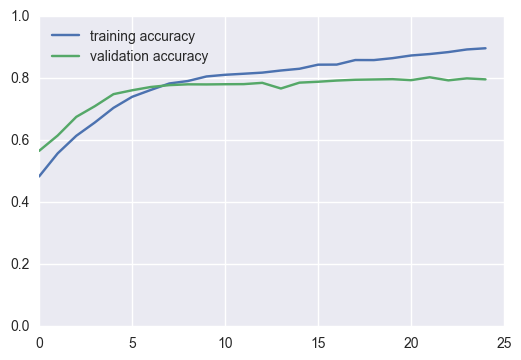

In [28]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(train_acc, label = 'training accuracy')
plt.plot(val_acc, label = 'validation accuracy')
plt.legend(loc = 0)
plt.ylim(0,1)
print('training accuracy:', train_acc[-1])
print('validation accuracy:', val_acc[-1])

- min_word: 2
    - Conv(20,3) -> GMP -> 3 => (0.745, 0.766)
    - Conv(20,5) -> GMP -> 3 => (0.764, 0.781)
    - Conv(20,10) -> GMP -> 3 => (0.733, 0.711)
    - Conv(50,3) -> GMP -> 3 => (0.754, 0.777)
    - Conv(50,5) -> GMP -> 3 => (0.754, 0.771)
    - Conv(50,5) -> GMP -> 250 -> 3 => (0.550, 0.439)
    - Conv(100,5) -> GMP -> 20 -> 3 => (0.760, 0.772)

In [240]:
from sklearn.metrics import confusion_matrix, accuracy_score

def proba_to_prediction(predict_probas):
    predictions = np.array([np.argmax(row) for row in predict_probas])
    return predictions

def evaluate(y, y_pred):
    print('accuracy:', accuracy_score(y, y_pred))
    print('confusion matrix:\n', confusion_matrix(y, y_pred))
    
def flatten(y):
    y_cat = y.copy()
    y_cat[:,0] = 0
    y_cat[:,2] = y_cat[:,2] * 2
    y_cat = y_cat.sum(axis = 1)
    return y_cat

In [242]:
predict_probas = cnn.predict(X_test)
#y_orig = df_clean.is_hate_speech
y_pred = proba_to_prediction(predict_probas).reshape(-1)
y_test_flatten = flatten(y_test).reshape(-1)
evaluate(y_test_flatten, y_pred)

accuracy: 0.816678152998
confusion matrix:
 [[1356   58   20]
 [  84  693  182]
 [  24  164  321]]


# What if we collapse offensive and hate speech into a single category

In [244]:
y_binary = (y_test_flatten == 1) | (y_test_flatten == 2)
y_pred_binary = (y_pred == 1) | (y_pred == 2)
evaluate(y_binary, y_pred_binary)

accuracy: 0.935906271537
confusion matrix:
 [[1356   78]
 [ 108 1360]]


In [256]:
def tweet_rater(tweet):
    tweet = replace_user(tweet)
    tweet = clean_tweet(tweet)
    tweet = normalize(tweet)
    print(tweet)
    x_vect = tokenizer.texts_to_sequences([tweet])
    x_vect = pad_sequences(x_vect, maxlen = max_sequence_length, padding = 'post', truncating = 'post')
    probas = cnn.predict(x_vect)[0]
    print(probas)
    rating = np.argmax(probas)
    if rating == 0:
        print('I\'m {:2.4}% sure that\'s not offensive.'.format(probas[0]*100))
    elif rating == 1:
        print('I\'m {:2.4}% sure that\'s offensive.'.format(probas[1]*100))
    else:
        print('I\'m {:2.4}% sure that\'s hate speech.'.format(probas[2]*100))

In [271]:
tweet_rater('worse than isis in america')

worse than isis in america
[ 0.01730748  0.40231907  0.58037347]
I'm 58.04% sure that's hate speech.


In [580]:
df = df.reindex(df_clean.index)

In [251]:
y_all_pred = cnn.predict(X)
y_all_pred = proba_to_prediction(y_all_pred)
y_all = df_clean.is_hate_speech

# Non-offensive speech classified as offensive

In [252]:
df_orig = df.reindex(df_clean.index)

In [253]:
df_orig[(y_all == 0) & (y_all_pred == 1)]

,text,is_hate_speech
id,,
853718253,I play for keeps you play wit me its gon be yellow tape! #200,0
853719470,@RobotZo @Akbar_Knows I'm not even in this,0
853719692,@MarissaWolff_ I hope so too cuz Kurt Sutter's recent show he made after Sons was The Bastard Executioner &amp; it was horrible,0
853719707,@RobbieCrolley well in Jammy bastard,0
853719800,In which @JRubinBlogger pretends blacks support legalization of illegal immigrants in US. https://t.co/CoIUUSQAwF,0
853719925,"@httpjoselle love ya so much, chink_�㢉�_��",0
853719936,I should have got some food I'm tired of cleaning for this damn party,0
853719942,Lil short ass_�㢉�__,0
853719960,Some temptations are harder to fight than others,0


# Non-offensive speech classified as hate speech

In [254]:
df_orig[(y_all == 0) & (y_all_pred == 2)]

,text,is_hate_speech
id,,
853718254,@LastProtestants @stomponato @delschilling You're an idiot.,0
853719599,Conservatism is worse than isis in America,0
853719663,"Universal truth: white ppl, no matter where you are, can't control they kids",0
853720378,"#tiara,son&amp;fags @tweeter_anita @PindarDiamond https://t.co/SYYgoGDMmL",0
853720400,�_�1.50 and a pack of fags? Could of got a freddo mate,0
853720589,"homo, pain, death....... https://t.co/cVNAbYHZDw",0
853720701,@PhoneBoy @GummyNerds @tsaoutourpants I think people are beginning to understand; Would a Nazi allow a Jew to opt out of #DeathCamp shower?,0
853721102,.@GovernorPataki discusses radical Islam as a threat to US. https://t.co/gNCKX01E1c #NSASNH #GJM https://t.co/pGdYBqxuTG,0
853721138,@BadhbhCatha The same chance as a heterosexual has of being raped by a male one.,0


# Offensive speech classified as non-offensive

In [258]:
df_orig[(y_all == 1) & (y_all_pred == 0)]

,text,is_hate_speech
id,,
853718269,"RT @JoeBudden: Young, attractive, successful, supportive, faithful man w his own everything..u think bringing solely pussy to the table is &#8230;",1
853719534,Wallahi i only love the muslims for the sake of Allah and i hate for them what i hate for myself so i advise everyone and myself firstly,1
853719615,"Women: ""a man should pay the rent and all the bills, I'm traditional""\n\nMen: keep your body count low\n\nWomen: ""You're a ashy misogynist!""",1
853719654,You ever got a nude from a girl with a ashy booty?! Lmaooooooll,1
853719662,"Nothing says ""I�ʉ����m a fat bastard"" like wearing a T-shirt in a swimming pool.",1
853719669,"i really want to know carol's maiden name, i don't like that we only know her as that bastard's name",1
853719676,ME &amp; 100 MILLION OTHER REAL AMERICANS ARE LOOKING FORWARD TO SEEING YOU IN HELL WITH YOUR STINKIN' ASS ON FIRE!!! YOU RACIST BASTARD!!!,1
853719681,"I've reached the conclusion that this is impossible to respond to. I should have staked the bastard. Next best thing, then...",1
853719686,Four bastard sacks of recycling later and I've finally rid the flat of all pre-Christmas cardboard boxes and shizzle. #winning,1


# Hate speech classified as non-offensive

In [259]:
df_orig[(y_all == 2) & (y_all_pred == 0)]

,text,is_hate_speech
id,,
853719773,@TheEricCarter @JaredWyand @cristinalaila1 YES White America is a LOT better than Muslim S Arabia. Blacks are way more racist than whites.,2
853719976,"@glen76stephens how can I forget about you,ya post the Chinks,eggs,chips and beans bollocks ye",2
853719984,how do chinks eat rice with chopsticks?,2
853719985,They goin sale America to the chinks before they give a black man such power _��_�۝_�㢉�___��̻_,2
853720386,@a_man_in_yellow its no even that\n&gt;ruin the reputation of anime\nwhat reputation? of weeb fags speaking in broken jap and dressing as naruto?,2
853720405,What's with basketball players wearing yoga pants under their shorts? Fags,2
853721017,_��_� _��__ Any Queers in the Theater tonight?\nGet em up against the Wall...\nThat one looks Jewish\nAnd another with Spots!\n\nhttps://t.co/0FR5tTkXyc,2
853721384,Spic santa is coming down your chimney with a machete.,2
853721467,So ur name is also Khan and I'm sure ur a terrorist @sanwarkhan14 @Aghorii2 @HDL_Global,2


# Correctly identified hate speech

In [260]:
df_orig[(y_all == 2) & (y_all_pred == 2)]

,text,is_hate_speech
id,,
853718219,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandonernandez @bootyacid at least i dont look like jefree starr faggot,2
853718220,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkillah Is a fag"" jackie jealous"" Neeeee",2
853718222,"@elaynay your a dirty terrorist and your religion is a fucking joke, you go around screaming Allah akbar doing terrorist shit. Dirty faggot.",2
853718223,RT @ivanrabago_: @_WhitePonyJr_ looking like faggots?,2
853718224,Well I thought you knew actually RT @KingHorseDick: Man why y'all didn't tell me I was a dick riding ass faggot? Y'all not real &#128557;&#128557;&#128557;&#128557;&#128557;&#128557;,2
853718227,#VoteBlue2014 Yeah. CUZ 8 million people in faggot ass #newyork are #chickenshit JEWS&gt; FUCK THEM right? Fuck Bibi Netanyahu. RIGHT?,2
853718228,"@AndreBerto word is you use roids, stupid hypocrite lying faggot.",2
853718229,I hate faggots like you,2
853718230,@MoriTaheripour shut up nigger whore! Hope u get raped by one of those animals. Might change your tune.,2


# Correctly identified offensive speech

In [261]:
df_orig[(y_all == 1) & (y_all_pred == 1)]

,text,is_hate_speech
id,,
853718226,I'm tired of people saying I look like my brother &amp; calling me Deondre' like serious Succ My Ass fag asses,1
853718234,I cant stand no crybaby ass nigga. If you gonna act like a bitch I will leave yo ass after I instavideo yo stupid lookin ass,1
853718236,"""I'll fuck you til you love me faggot"" - Mike Tyson",1
853718260,I was with a bitch with a mustash for a year and a half? Wtf is wrong itch me,1
853718261,"RT @skythedon: Huge ass, small waist &amp; okay face &amp; bitches really think they famous",1
853718262,Bobby flay in this bitch,1
853718263,I'm never gonna be ok with my nigga around alot of bitches while with his boys. Cause I was once that female your boys put you on !!,1
853718264,Where the bad bitches at? Lol @Vbomb20,1
853718265,RT @KayciMalynn: I just can't help but to hate you. Even though you never intentionally did anything to me you're still a cunt. #girllogic,1


# Correctly identified non-hate speech

In [262]:
df_orig[(y_all == 0) & (y_all_pred == 0)]

,text,is_hate_speech
id,,
853718239,RT @Fact: Some species of birds have been known to hold funerals for their deceased.,0
853718240,"I remember Draft prom night, my dress wouldn't zip up and I was bawling my eyes out and screaming I didn't want to go... So funny. Haha.",0
853718241,Damn Eli. That's just ruff. I'm not even gonna trash talk that one. Get your game together Eli. You're a good QB. Stop with the TO's,0
853718242,"Also, Happy Armistice Day, anachronists!\n\n&#8220;The Hun is either at your throat or at your feet.&#8221; - Churchill",0
853718243,@ExpSelf A friend suggested I dress as a Fairy for a Halloween party we're attending...I'm thinking more Wizardess of course. :),0
853718244,RT @BitchPlsComedy: apparently &#8220;bae&#8221; means &#8220;before anyone else&#8221; i always thought it was a ghetto word for &#8220;babe&#8221;,0
853718245,@RiotSupport so I was suspended for a day because of a random lag spikes that force me to close the client and relog and suspended. GG,0
853718246,#Flyers w/ some moxy! Big comeback again!!! Major penalty killed the Caps.Great game. 5 cases of #tastycakes,0
853718247,pollo&#128523;&#128523;&#128523;,0
